# Sentiment analysis of collected tweets

---



# Importing libraries

In [691]:
!pip install unidecode

In [692]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from string import punctuation
from wordcloud import WordCloud
from nltk import tokenize


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import unidecode
import nltk

In [693]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

# Loading data

## Loading the datasets

In [694]:
df_tweets = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/1. Organização dos Dados Coletados/0. Dados Organizados/Tweets.csv")
df_bitcoin = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/1. Organização dos Dados Coletados/0. Dados Organizados/BTC-organized.csv")

Adjusting the data types from tweets dataframe

In [695]:
df_tweets['Tweet'] = df_tweets['Tweet'].astype(str)
df_tweets['User'] = df_tweets['User'].astype(str)
df_tweets['Date'] = df_tweets['Date'].astype('datetime64[ns]')
df_tweets = df_tweets[['Tweet', 'User', 'Date']]
df_tweets

,Tweet,User,Date
0,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-10-03
1,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-09-11
2,43k,@100trillionUSD,2021-09-07
3,"Do you think #bitcoin will reach $500K, $288K ...",@100trillionUSD,2021-08-15
4,So was $64K the top for this cycle (halving 20...,@100trillionUSD,2021-07-01
...,...,...,...
64940,And it's started... #tedxtearo nice work guys!,@woonomic,2012-11-30
64941,On knowledge: Circa 1400 a book cost you the p...,@woonomic,2011-03-07
64942,"Opened up my new MacBook Pro 13 Unibody. Wow, ...",@woonomic,2009-10-09
64943,GMail Tip: just discovered you can drag label...,@woonomic,2009-07-29


Auxiliary tweets dataset

In [696]:
df_only_tweets = df_tweets[['Tweet', 'Date']]

Adjusting the data type from from 

In [697]:
df_bitcoin['Date'] = df_bitcoin['Date'].astype('datetime64[ns]')
df_bitcoin

,Date,Price,Uprise
0,2021-10-18,62026.078125,1
1,2021-10-17,61553.617188,1
2,2021-10-16,60892.179688,0
3,2021-10-15,61593.949219,1
4,2021-10-14,57321.523438,0
...,...,...,...
2584,2014-09-21,398.821014,0
2585,2014-09-20,408.903992,1
2586,2014-09-19,394.795990,0
2587,2014-09-18,424.440002,0


## Joining bitcoin and tweets datasets

In [698]:
df_only_tweets

,Tweet,Date
0,"Do you think #bitcoin will reach $500K, $288K ...",2021-10-03
1,"Do you think #bitcoin will reach $500K, $288K ...",2021-09-11
2,43k,2021-09-07
3,"Do you think #bitcoin will reach $500K, $288K ...",2021-08-15
4,So was $64K the top for this cycle (halving 20...,2021-07-01
...,...,...
64940,And it's started... #tedxtearo nice work guys!,2012-11-30
64941,On knowledge: Circa 1400 a book cost you the p...,2011-03-07
64942,"Opened up my new MacBook Pro 13 Unibody. Wow, ...",2009-10-09
64943,GMail Tip: just discovered you can drag label...,2009-07-29


Agroup the dataset lines by date

In [699]:
df_tweets_by_date = df_only_tweets.groupby('Date', as_index=False)['Tweet'].apply(' '.join)

Adjusting the order by the most recent date

In [700]:
df_tweets_by_date.sort_values(by='Date', ascending=False, ignore_index=True, inplace=True)
df_tweets_by_date

,Date,Tweet
0,2021-10-18,$62K is the new $200. (\_/)\n( •_•)\n/ > This ...
1,2021-10-17,UP ONLY #BITCOIN \n \n ...
2,2021-10-16,First word that pops into your head when you h...
3,2021-10-15,Who is your favorite YouTuber that makes conte...
4,2021-10-14,"$69,420 bitcoin price will break the internet...."
...,...,...
3113,2009-05-02,@laurashin @laurashin @laurashin
3114,2009-04-29,@laurashin
3115,2009-04-23,@laurashin @laurashin
3116,2009-04-22,@laurashin @laurashin @laurashin @laurashin


In [701]:
df_bitcoin

,Date,Price,Uprise
0,2021-10-18,62026.078125,1
1,2021-10-17,61553.617188,1
2,2021-10-16,60892.179688,0
3,2021-10-15,61593.949219,1
4,2021-10-14,57321.523438,0
...,...,...,...
2584,2014-09-21,398.821014,0
2585,2014-09-20,408.903992,1
2586,2014-09-19,394.795990,0
2587,2014-09-18,424.440002,0


In [702]:
bitcoin_dates = df_bitcoin['Date'].to_list()
tweets_dates =  df_tweets_by_date['Date'].to_list()

Removing the dates from tweet dataset that aren't in bitcoin dataset

In [703]:
new_tweets_dates = list()

x = 0
for date_tweet in tweets_dates:
  if date_tweet not in bitcoin_dates:
    df_tweets_by_date.drop(index=x, axis=0, inplace=True)
  x += 1

    

In [704]:
df_tweets_by_date

,Date,Tweet
0,2021-10-18,$62K is the new $200. (\_/)\n( •_•)\n/ > This ...
1,2021-10-17,UP ONLY #BITCOIN \n \n ...
2,2021-10-16,First word that pops into your head when you h...
3,2021-10-15,Who is your favorite YouTuber that makes conte...
4,2021-10-14,"$69,420 bitcoin price will break the internet...."
...,...,...
2560,2014-09-21,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...
2561,2014-09-20,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...
2562,2014-09-19,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...
2563,2014-09-18,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...


In [705]:
df_tweets_bitcoin = pd.merge(df_tweets_by_date, df_bitcoin) # (df_only_tweets['Tweet', 'Date'], df_bitcoin['Uprise']

In [706]:
df_tweets_bitcoin = df_tweets_bitcoin[['Tweet', 'Date', 'Uprise']]
df_tweets_bitcoin

,Tweet,Date,Uprise
0,$62K is the new $200. (\_/)\n( •_•)\n/ > This ...,2021-10-18,1
1,UP ONLY #BITCOIN \n \n ...,2021-10-17,1
2,First word that pops into your head when you h...,2021-10-16,0
3,Who is your favorite YouTuber that makes conte...,2021-10-15,1
4,"$69,420 bitcoin price will break the internet....",2021-10-14,0
...,...,...,...
2560,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...,2014-09-21,0
2561,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...,2014-09-20,1
2562,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...,2014-09-19,0
2563,@CryptoCobain @CryptoCobain @CryptoCobain @Cry...,2014-09-18,0


## Organizing the datasets with different configuration

Transform date columns in lists

In [707]:
bitcoin_dates = df_bitcoin['Date'].to_list()
tweets_dates =  df_only_tweets['Date'].to_list()
uprise_list = df_bitcoin['Uprise'].to_list()

In [708]:
bitcoin_dates[2588]

Timestamp('2014-09-17 00:00:00')

In [709]:
query = (df_only_tweets['Date'] >= bitcoin_dates[2588])
df_only_tweets = df_only_tweets[query]

Removing the dates from bitcoin dataset that aren't in tweet dataset

In [710]:
x = 0
for date_tweet in tweets_dates:
  if date_tweet not in bitcoin_dates:
    df_only_tweets.drop(index=x, axis=0, inplace=True)
    if x <= len(df_only_tweets['Date']):
      x+=1


    

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [711]:
tweets_dates.sort(reverse=True)

In [712]:
tweets_dates.index(bitcoin_dates[2588])

63304

In [713]:
new_cotation = list()

for date_tweet in tweets_dates:
  if date_tweet in bitcoin_dates:
    index_date = bitcoin_dates.index(date_tweet)
    new_cotation.append(uprise_list[index_date])
    

In [714]:
len(new_cotation)

63318

In [715]:
len(df_only_tweets['Tweet'])

61691

In [716]:
new_cotation =  pd.Series(new_cotation)
new_cotation

0        1
1        1
2        1
3        1
4        1
        ..
63313    1
63314    1
63315    1
63316    1
63317    1
Length: 63318, dtype: int64

In [717]:
df_only_tweets

,Tweet,Date
1627,Freedom to speak.\nFreedom to think.\nFreedom ...,2021-02-26
1628,Good morning to everyone except the people who...,2021-02-26
1629,The bitcoin memes have done more for marketing...,2021-02-26
1630,"Inflation is not 2%.\n\nIf you claim it is, yo...",2021-02-26
1631,Honestly I’d pay \n@nouriel\n and \n@PeterSchi...,2021-02-25
...,...,...
64933,Whatever you resist will persist. Banks resist...,2016-10-28
64934,OMG!,2015-12-21
64935,#Bitcoin #1 risk is centralisation of enginee...,2015-12-20
64936,Hey \n@8iReality\n - did we ever get that VR \...,2015-12-17


In [718]:
df_tweets_increase = df_only_tweets
df_tweets_increase['Raise'] = new_cotation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [719]:
df_tweets_increase.dropna(inplace=True)
df_tweets_increase.sort_values(by='Date', ascending=False, ignore_index=True, inplace=True)

df_tweets_increase['Raise'] = df_tweets_increase['Raise'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aft

# Analyze of tweets column with a Word Cloud

A list of all phrase

In [720]:
all_phrase = [tweet for tweet in df_tweets_bitcoin['Tweet']]

Agglutinating the phrase

In [721]:
agg_phrase = ' '.join(all_phrase)

Creating the Word Cloud

In [722]:
tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phrase)

Plotting the word cloud


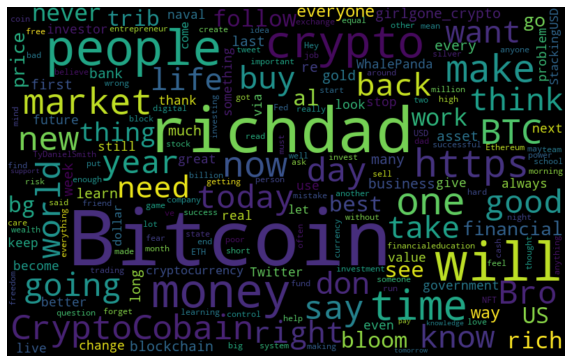

In [723]:
plt.figure(figsize=(10, 7))
plt.imshow(tw_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tokenization to create a new view

Tokenization with white spaces

In [724]:
all_phases = [tweet for tweet in df_tweets_bitcoin['Tweet']]
agg_phases = ' '.join(all_phases)

In [725]:
tokenizer_white_spaces = tokenize.WhitespaceTokenizer()
tokenized_phases = tokenizer_white_spaces.tokenize(agg_phases)
frequency = nltk.FreqDist(tokenized_phases)

## Creating a DataFrame to analyse the frequency

In [726]:
df_tw_words_frequency = pd.DataFrame(
    {
        'Words': list(frequency.keys()),
        'Frequency': list(frequency.values())
    }
)


In [727]:
df_tw_words_frequency.head()

,Words,Frequency
0,$62K,1
1,is,19840
2,the,35651
3,new,1307
4,$200.,7


In [728]:
top_10_frequent_words = df_tw_words_frequency.nlargest(columns='Frequency', n=10)
top_10_frequent_words

,Words,Frequency
2,the,35651
14,to,29768
66,a,21400
1,is,19840
16,of,18347
73,and,17749
45,you,14644
179,in,13151
95,for,10347
185,I,9082


View of the top 10 most frequent words

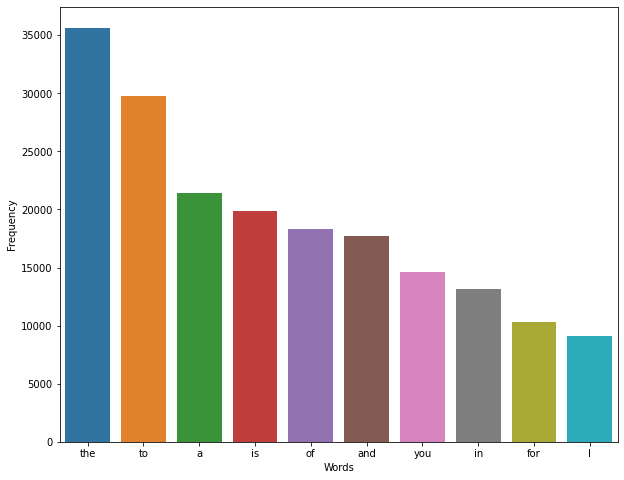

In [729]:
plt.figure(figsize=(10,8))
sns.barplot(data=top_10_frequent_words, x='Words', y='Frequency')
plt.show()

This words doesn't add up to our analysis, will be necessary to clean some of this words before start the sentiment analysis

# Tweets column optimization pipeline

## Functions to help the visualization

Functioin to plot a word cloud

In [730]:
def word_cloud_tweets(text, column_text):
  all_phrase = [tweet for tweet in text[column_text]]
  agg_phrase = ' '.join(all_phrase)
  tw_wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(agg_phases)
  plt.figure(figsize=(10, 7))

  plt.imshow(tw_wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


Function to plot of the top 10 most frequent words

In [731]:
def top_most_frequent(text, column_text, length, title):
  all_phases = [tweet for tweet in text[column_text]]
  agg_phases = ' '.join(all_phases)
  tokenizer_white_spaces = tokenize.WhitespaceTokenizer()
  tokenized_phases = tokenizer_white_spaces.tokenize(agg_phases)
  frequency = nltk.FreqDist(tokenized_phases)
  df_tw_words_frequency = pd.DataFrame(
      {
          'Words': list(frequency.keys()),
          'Frequency': list(frequency.values())
      }
  )
  top_10_frequent_words = df_tw_words_frequency.nlargest(columns='Frequency', n=length)

  plt.figure(figsize=(10,8))
  plt.title(title)
  sns.barplot(data=top_10_frequent_words, x='Words', y='Frequency')
  plt.show()

## Data processing 1

To remove some of this words, will be used the stopwords from nltk library

In [732]:
initial_stopwords = nltk.corpus.stopwords.words("english")
initial_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [733]:
processed_phrase = list()

for tweet in df_tweets_increase['Tweet']:
  new_phrase = list()
  words_txt = tokenizer_white_spaces.tokenize(tweet)
  for word in words_txt:
    if word not in initial_stopwords:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_1'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Word Cloud View

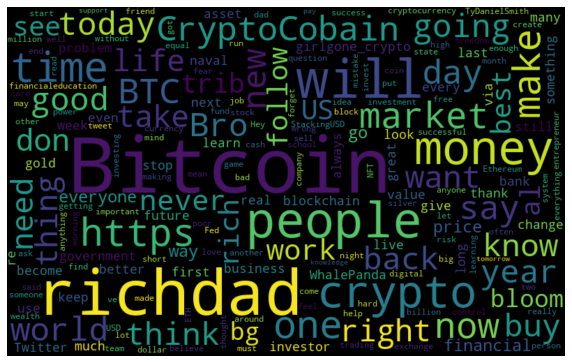

In [734]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_1')

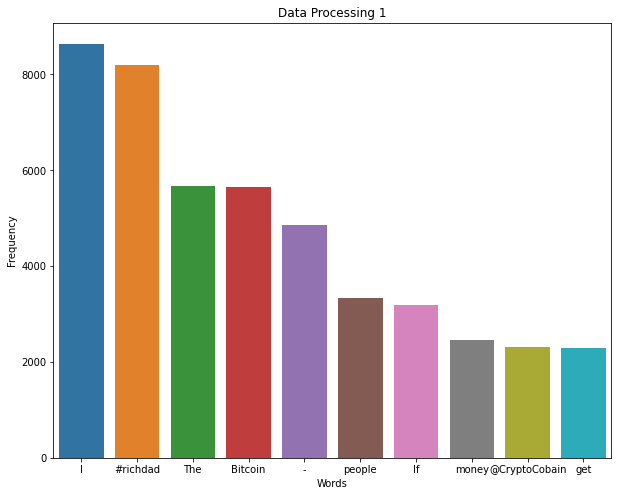

In [735]:
top_most_frequent(df_tweets_increase, 'Data_processing_1', 10, 'Data Processing 1')

Comparation: Original x Data Processing 1

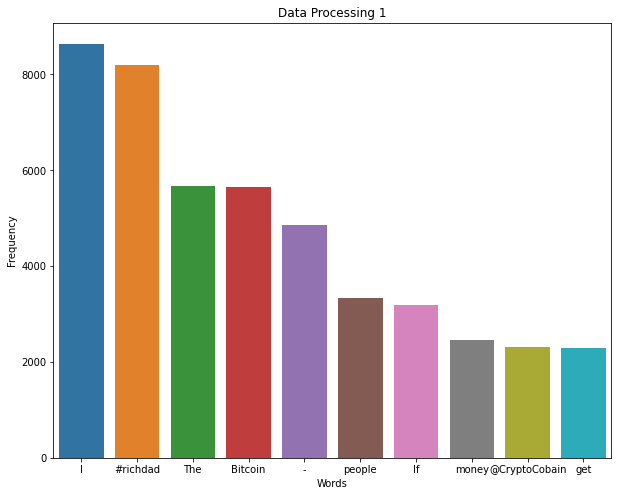

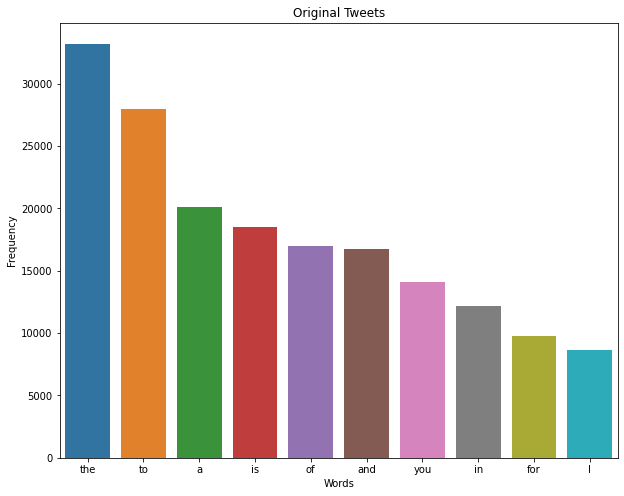

In [736]:
top_most_frequent(df_tweets_increase, 'Data_processing_1', 10, 'Data Processing 1')

top_most_frequent(df_tweets_increase, 'Tweet', 10, 'Original Tweets')


## Data processing 2

Optimizing the tokenization

In [737]:
tokenizer_punctuation = tokenize.WordPunctTokenizer()
tokenized_phases = tokenizer_punctuation.tokenize(agg_phases)

New stopwords with the punctuations

In [738]:
punctuation_sw = [element for element in punctuation]

In [739]:
# stopwords_and_punctuation = initial_stopwords + punctuation_sw
# stopwords_and_punctuation.append('://')

Removing the profile names citations on their tweets

In [780]:
profiles = pd.read_csv("/content/drive/MyDrive/DI - Analise Bitcoin - GPU/4. Execução/ Jupyter antigos/01 | Coleta de dados/01 | Twitter/perfis_twitter.csv")
profile_list = profiles['Perfis Twitter'].to_list()
stop_words_profiles_and_punctuation = profile_list + punctuation_sw

In [781]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_1']:
  new_phrase = list()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stop_words_profiles_and_punctuation:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_2'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


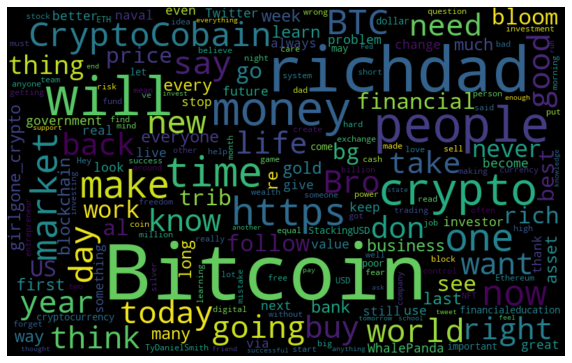

In [782]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_2')

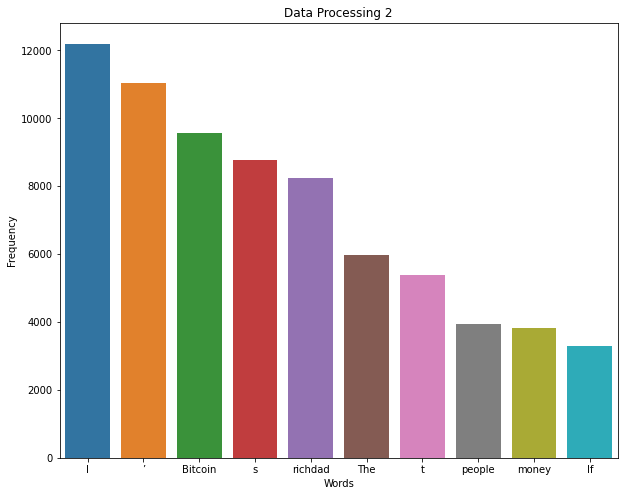

In [783]:
top_most_frequent(df_tweets_increase, 'Data_processing_2', 10, 'Data Processing 2')

## Data processing 3

In [744]:
stopwords_no_unicode =  [unidecode.unidecode(text) for text in stopwords_and_punctuation]

Removing unicode elementes from the corpus

In [784]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_2']:
  new_phrase = list()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_3'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


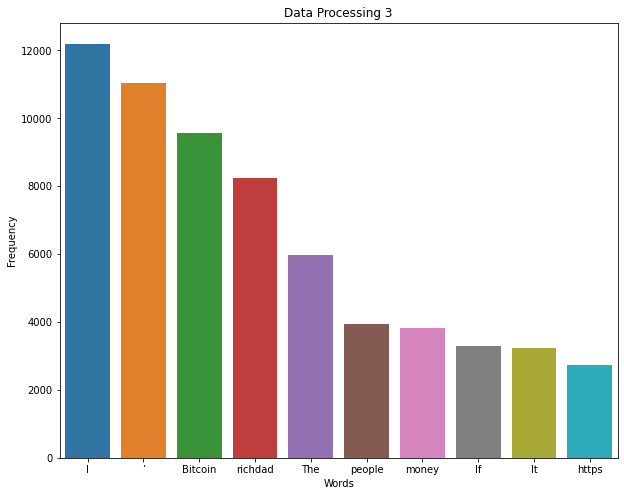

In [785]:
top_most_frequent(df_tweets_increase, 'Data_processing_3', 10, 'Data Processing 3')

## Data processing 4

Removing uppercase letters

In [786]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_3']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(word)
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_4'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


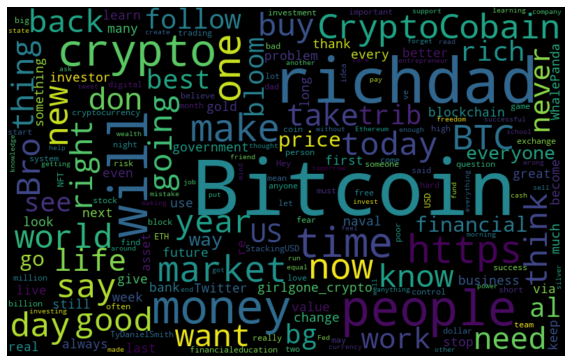

In [748]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_4')

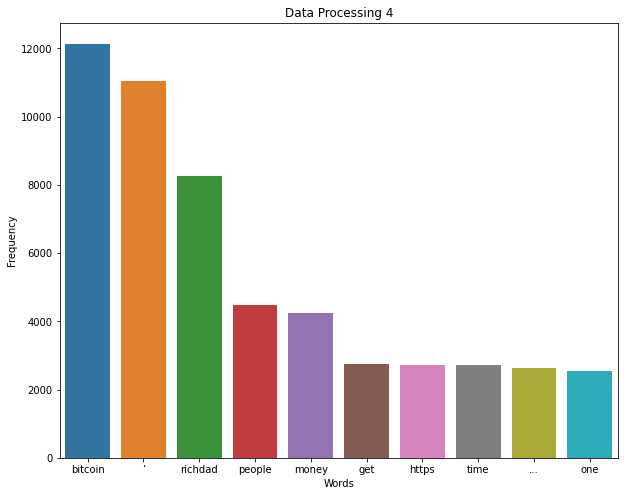

In [787]:
top_most_frequent(df_tweets_increase, 'Data_processing_4', 10, 'Data Processing 4')

## Data processing 5

In [788]:
stemmer = nltk.PorterStemmer()

In [789]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_4']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(stemmer.stem(word))
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_5'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


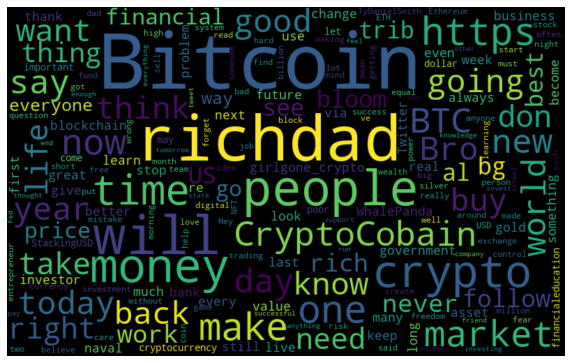

In [752]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_5')

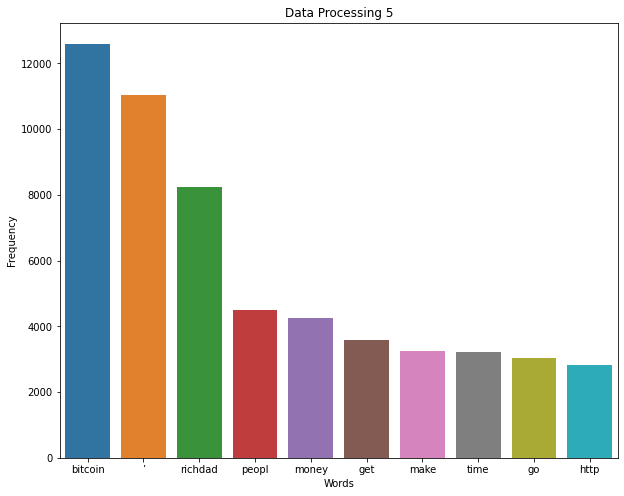

In [790]:
top_most_frequent(df_tweets_increase, 'Data_processing_5', 10, 'Data Processing 5')

## Data processing 6

In [791]:
sno = nltk.stem.SnowballStemmer('english')

In [792]:
processed_phrase = list()

for tweet in df_tweets_increase['Data_processing_5']:
  new_phrase = list()
  tweet = tweet.lower()
  words_txt = tokenizer_punctuation.tokenize(tweet)
  for word in words_txt:
    if word not in stopwords_no_unicode:
      new_phrase.append(sno.stem(word))
  processed_phrase.append(' '.join(new_phrase))
df_tweets_increase['Data_processing_6'] = processed_phrase

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


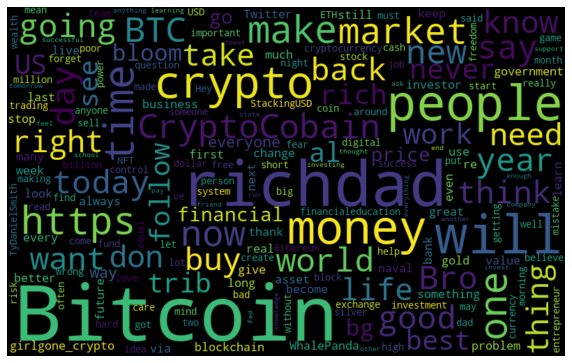

In [793]:
word_cloud_tweets(df_tweets_increase, 'Data_processing_6')

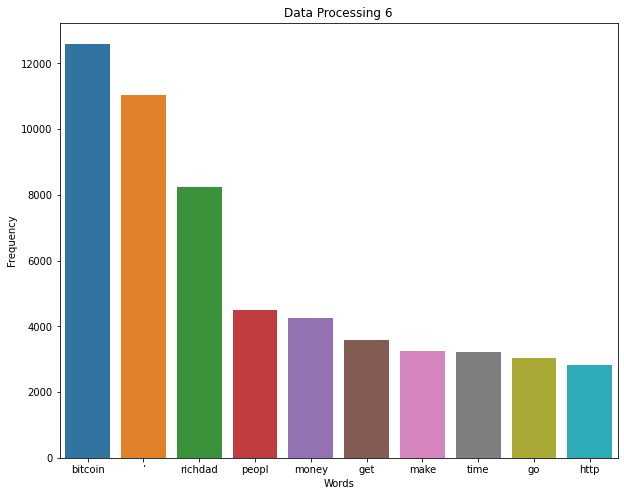

In [794]:
top_most_frequent(df_tweets_increase, 'Data_processing_6', 10, 'Data Processing 6')

# Development of Sentiment Analysis

## Dataset: df_tweets_increase

### Function to help the development of the classification model

### LogisticRegression

In [795]:
def classify_texts_bag_of_words(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  bw_vectorizer = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = bw_vectorizer.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      bag_of_words, # X
      dataset[label_column], # Y
      random_state = 42 
      )
  
  # Logistical Regression - Training
  logistical_regression = LogisticRegression(solver='lbfgs')
  logistical_regression.fit(x_train, y_label_train)

  # Logistical Regression - Accuracy Score
  acry_score = logistical_regression.score(x_test, y_label_test)

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)*100) + "%")

In [796]:
def classify_texts_tfidf(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  tfidf_vectorizer = TfidfTransformer()
  tfdif = TfidfVectorizer(lowercase=False, max_features=50)
  raw_tfidf = tfdif.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      raw_tfidf, # X
      dataset[label_column], # Y
      random_state = 42 
      )
  
  # Logistical Regression - Training
  logistical_regression = LogisticRegression(solver='lbfgs')
  logistical_regression.fit(x_train, y_label_train)

  # Logistical Regression - Accuracy Score
  acry_score = logistical_regression.score(x_test, y_label_test)

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)*100) + "%")



### MultinomialNB

In [797]:
def classify_texts_bag_of_words_crosvalidate(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  bw_vectorizer = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = bw_vectorizer.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      bag_of_words, # X
      dataset[label_column], # Y
      random_state = 42 
      )
    
  model = MultinomialNB()
  
  # LMultinomialNB - Training
  model.fit(x_train, y_label_train)
  predictions = model.predict(x_test)


  # LMultinomialNB - Accuracy Score
  acry_score =  accuracy_score(y_label_test, predictions) * 100

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)) + "%")

### DecisionTreeClassifier

In [798]:
def classify_texts_bag_of_words_DecisionTreeClassifier(dataset, text_column, label_column, model_name):
  # Bag of words vectorizer
  bw_vectorizer = CountVectorizer(lowercase=False, max_features=50)
  bag_of_words = bw_vectorizer.fit_transform(dataset[text_column])

  # Model
  x_train, x_test, y_label_train, y_label_test = train_test_split(
      bag_of_words, # X
      dataset[label_column], # Y
      random_state = 42 
      )
  SEED = 158020
  np.random.seed(SEED)
  model = DecisionTreeClassifier(max_depth=100)
  
  
  # LMultinomialNB - Training
  model.fit(x_train, y_label_train)
  predictions = model.predict(x_test)


  # LMultinomialNB - Accuracy Score
  acry_score =  accuracy_score(y_label_test, predictions) * 100

  return acry_score,  print("The accuracy score of the model {}".format(model_name) + " is {:.3f}".format((acry_score)) + "%")

### Classification model pipeline with bag of words - LogisticRegression

#### Classification model with not processed data

In [799]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Tweet', 'Raise', 'RAW MODEL')
accuracy_txt

The accuracy score of the model RAW MODEL is 53.251%


#### Classification model with first processed data

In [800]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_1', 'Raise', 'DATA PROCESSING 1')
accuracy_txt

The accuracy score of the model DATA PROCESSING 1 is 53.671%


#### Classification model with second processed data

In [801]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_2', 'Raise', 'DATA PROCESSING 2')
accuracy_txt

The accuracy score of the model DATA PROCESSING 2 is 53.358%


#### Classification model with tird processed data

In [802]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_3', 'Raise', 'DATA PROCESSING 3')
accuracy_txt

The accuracy score of the model DATA PROCESSING 3 is 52.978%


#### Classification model with fourth processed data 

In [803]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_4', 'Raise', 'DATA PROCESSING 4')
accuracy_txt

The accuracy score of the model DATA PROCESSING 4 is 53.291%


#### Classification model with fifth processed data

In [804]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_5', 'Raise', 'DATA PROCESSING 5')
accuracy_txt

The accuracy score of the model DATA PROCESSING 5 is 53.131%


#### Classification model with sixth processed data

In [805]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words(df_tweets_increase, 'Data_processing_6', 'Raise', 'DATA PROCESSING 6')
accuracy_txt

The accuracy score of the model DATA PROCESSING 6 is 53.171%


### Classification model pipeline with tfidf - LogisticRegression

#### Classification model with not processed data

In [806]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Tweet', 'Raise', 'RAW MODEL')
accuracy_txt

The accuracy score of the model RAW MODEL is 53.378%


#### Classification model with first processed data

In [807]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_1', 'Raise', 'DATA PROCESSING 1')
accuracy_txt

The accuracy score of the model DATA PROCESSING 1 is 53.977%


#### Classification model with second processed data

In [808]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_2', 'Raise', 'DATA PROCESSING 2')
accuracy_txt

The accuracy score of the model DATA PROCESSING 2 is 53.577%


#### Classification model with tird processed data

In [809]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_3', 'Raise', 'DATA PROCESSING 3')
accuracy_txt

The accuracy score of the model DATA PROCESSING 3 is 53.697%


#### Classification model with fourth processed data 

In [810]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_4', 'Raise', 'DATA PROCESSING 4')
accuracy_txt

The accuracy score of the model DATA PROCESSING 4 is 53.537%


#### Classification model with fifth processed data

In [811]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_5', 'Raise', 'DATA PROCESSING 5')
accuracy_txt

The accuracy score of the model DATA PROCESSING 5 is 53.677%


#### Classification model with sixth processed data

In [812]:
model_accuracy, accuracy_txt = classify_texts_tfidf(df_tweets_increase, 'Data_processing_6', 'Raise', 'DATA PROCESSING 6')
accuracy_txt

The accuracy score of the model DATA PROCESSING 6 is 53.611%


### Classification model with bag of words - Cross Validation

In [813]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words_crosvalidate(df_tweets_increase, 'Data_processing_6', 'Raise', 'DATA PROCESSING 6')
accuracy_txt

The accuracy score of the model DATA PROCESSING 6 is 53.418%


In [814]:
model_accuracy, accuracy_txt = classify_texts_bag_of_words_DecisionTreeClassifier(df_tweets_increase, 'Data_processing_6', 'Raise', 'DATA PROCESSING 6')
accuracy_txt

The accuracy score of the model DATA PROCESSING 6 is 52.253%
